In [1]:
'''Import of necessary libraries.'''

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from pandas_profiling import ProfileReport
import time
import math
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
import random
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import graphviz

In [2]:
'''Dataset creation.'''

!git clone https://github.com/slatkowski/autos_project
path_to_file = 'autos_project/autos.csv'
df = pd.read_csv(path_to_file)
df

fatal: destination path 'autos_project' already exists and is not an empty directory.


,index,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,...,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,...,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,...,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,...,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,...,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,...,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371523,371523,2016-03-14 17:48:27,Suche_t4___vito_ab_6_sitze,privat,Angebot,2200,test,NaN,2005,NaN,...,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
371524,371524,2016-03-05 19:56:21,Smart_smart_leistungssteigerung_100ps,privat,Angebot,1199,test,cabrio,2000,automatik,...,fortwo,125000,3,benzin,smart,nein,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
371525,371525,2016-03-19 18:57:12,Volkswagen_Multivan_T4_TDI_7DC_UY2,privat,Angebot,9200,test,bus,1996,manuell,...,transporter,150000,3,diesel,volkswagen,nein,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
371526,371526,2016-03-20 19:41:08,VW_Golf_Kombi_1_9l_TDI,privat,Angebot,3400,test,kombi,2002,manuell,...,golf,150000,6,diesel,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [3]:
'''Next we should count all values - function to use in this purpose is defined below.'''

def DFCounter(df):
    #1. Iteration over columns
    for col in df.columns:
        #2. Printing of every column values and their numbers
        print(df[col].value_counts())
        #3. Cross line to separate and make printing clear
        print('_______________________')
        
DFCounter(df)

0         1
247692    1
247690    1
247689    1
247688    1
         ..
123841    1
123840    1
123839    1
123838    1
371527    1
Name: index, Length: 371528, dtype: int64
_______________________
2016-03-24 14:49:47    7
2016-03-19 21:49:56    6
2016-03-26 22:57:31    6
2016-03-22 10:42:10    5
2016-04-01 16:52:05    5
                      ..
2016-03-20 15:56:21    1
2016-03-14 03:22:32    1
2016-03-14 22:52:34    1
2016-03-31 23:53:26    1
2016-03-07 19:39:19    1
Name: dateCrawled, Length: 280500, dtype: int64
_______________________
Ford_Fiesta                                              657
BMW_318i                                                 627
Opel_Corsa                                               622
Volkswagen_Golf_1.4                                      603
BMW_316i                                                 523
                                                        ... 
Audi_A4_Avant_Klima_Gruene_Plakette_TÜV_&AU_NEU_XENON      1
Renault_clio_in_gold_450VB_!

In [4]:
'''Replacing hidden missing values as NaN-s (in German: "andere" - "other"  
"sonstige autos" - "other cars").'''

df['brand'].replace('sonstige_autos', np.nan, inplace=True)
df.replace('andere', np.nan, inplace=True)

In [5]:
'''We have to check when the first and the last advertisement
have been published to make data filtering correct.'''

df['dateCreated'] = pd.to_datetime(df['dateCreated'])
df['lastSeen'] = pd.to_datetime(df['lastSeen'])

print(f"Date of the first advertisement: {df['dateCreated'].min()}.")
print(f"Date of the last advertisement: {df['dateCreated'].max()}.")

Date of the first advertisement: 2014-03-10 00:00:00.
Date of the last advertisement: 2016-04-07 00:00:00.


In [6]:
'''Column "index" contains unique values from 0 to 371528, so we can set it as index column.'''

df.set_index('index', inplace=True)

In [7]:
'''First information about a DataFrame columns names, non-null values and data types.
Columns "vehicleType", "gearbox", "model", "fuelType" and "notRepairedDamage" contain NaN values.
Also some of the columns which should be the base of prediction, like "vehicleType", "fuelType" or
"gearbox" are object (str) columns.'''

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   dateCrawled          371528 non-null  object        
 1   name                 371528 non-null  object        
 2   seller               371528 non-null  object        
 3   offerType            371528 non-null  object        
 4   price                371528 non-null  int64         
 5   abtest               371528 non-null  object        
 6   vehicleType          330302 non-null  object        
 7   yearOfRegistration   371528 non-null  int64         
 8   gearbox              351319 non-null  object        
 9   powerPS              371528 non-null  int64         
 10  model                324644 non-null  object        
 11  kilometer            371528 non-null  int64         
 12  monthOfRegistration  371528 non-null  int64         
 13  fuelType      

<Figure size 1000x600 with 0 Axes>

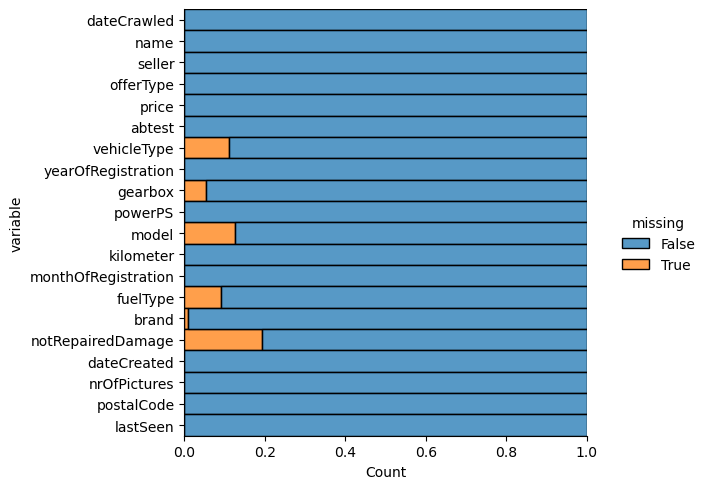

In [8]:
'''Displaying columns with NaN-s; columns "vehicleType", "gearbox", 
"model", "fuelType" and "notRepairedDamage" contain missing values.'''

plt.figure(figsize=(10,6))
sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)

plt.show()

In [9]:
'''Next, take a look at the descriptive statistics of DataFrame
(values round to two places after a comma to better readability).
Unfortunately, there are many outliers - maximum value of column "price"
overpasses 2 bilions of euro, we have value (values) with price = 0,
in column "yearOfRegistration" we have cars "registered" in year 1000 and 9999.
Also column "kilometer" may show not enough variance - max value (150000)
appears as a median.'''

df.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,371528.00,371528.00,371528.00,371528.00,371528.00,371528.00,371528.00
mean,17295.14,2004.58,115.55,125618.69,5.73,0.00,50820.67
std,3587953.74,92.87,192.14,40112.34,3.71,0.00,25799.08
min,0.00,1000.00,0.00,5000.00,0.00,0.00,1067.00
25%,1150.00,1999.00,70.00,125000.00,3.00,0.00,30459.00
50%,2950.00,2003.00,105.00,150000.00,6.00,0.00,49610.00
75%,7200.00,2008.00,150.00,150000.00,9.00,0.00,71546.00
max,2147483647.00,9999.00,20000.00,150000.00,12.00,0.00,99998.00


In [10]:
'''The next description of DataFrame - as we can see, NaNs have been replaced.
We can assume that the columns used in prediction should have numeric values
(except for column "nrOfPicture" in which we have only one value)
and columns "vehicleType", "gearbox", "fuelType" and "postalCode"
with values transformed into discrete numbers.'''

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   dateCrawled          371528 non-null  object        
 1   name                 371528 non-null  object        
 2   seller               371528 non-null  object        
 3   offerType            371528 non-null  object        
 4   price                371528 non-null  int64         
 5   abtest               371528 non-null  object        
 6   vehicleType          330302 non-null  object        
 7   yearOfRegistration   371528 non-null  int64         
 8   gearbox              351319 non-null  object        
 9   powerPS              371528 non-null  int64         
 10  model                324644 non-null  object        
 11  kilometer            371528 non-null  int64         
 12  monthOfRegistration  371528 non-null  int64         
 13  fuelType      

In [11]:
'''Next we have to drop the columns with no importance in modelling.'''

df.drop(columns=['dateCrawled', 'name', 'seller', 'offerType', 'abtest', 
                 'model', 'monthOfRegistration', 'notRepairedDamage', 
                 'dateCreated', 'nrOfPictures', 'lastSeen', 'kilometer', 'postalCode'], inplace=True)

print(df.columns)

Index(['price', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS',
       'fuelType', 'brand'],
      dtype='object')


In [12]:
'''Now we have to create two groups of brands (premium and other) instead of original car producers.'''

lst = [(['volkswagen', 'opel', 'ford', 'renault', 
         'peugeot', 'fiat', 'seat', 'mazda', 'skoda', 
         'citroen', 'nissan', 'toyota', 'hyundai',
        'mitsubishi', 'honda', 'kia', 'suzuki',
        'chevrolet', 'chrysler', 'dacia', 'daihatsu', 
        'subaru', 'trabant', 'daewoo', 'rover', 'lada'], 'Other brand'),
       (['bmw', 'mercedes_benz', 'audi', 'smart',
        'mini', 'volvo', 'alfa_romeo', 'porsche', 
        'land_rover', 'jaguar', 'lancia', 'saab', 'jeep'], 'Premium brand')]

repl_dict = {}
for x,y in lst:
    repl_dict.update(dict.fromkeys(x,y))

df['brand'] = df['brand'].replace(repl_dict)

print(df['brand'].value_counts())

Other brand      239348
Premium brand    128198
Name: brand, dtype: int64


In [13]:
'''The next operation is getting rid of outliers. We're taking into consideration only cars registered in the XXI century, 
with price in price bracket 200-40000 euros and engine power (in HP/PS) bracket 35 to 450 
(some of the brands have more powerful models, but they are not common and can be considered as outliers).
'''

df = df[(df['yearOfRegistration'] >= 2001) & (df['yearOfRegistration'] <= 2016)]
df = df[(df['price'] >= 200) & (df['price'] <= 40000)]
df = df[(df['powerPS'] >= 35) & (df['powerPS'] <= 450)]

In [14]:
'''We can see that operations above made the dataset about two times smaller.
Number of samples decreased about two times.'''

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205330 entries, 1 to 371527
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               205330 non-null  int64 
 1   vehicleType         196221 non-null  object
 2   yearOfRegistration  205330 non-null  int64 
 3   gearbox             202315 non-null  object
 4   powerPS             205330 non-null  int64 
 5   fuelType            197241 non-null  object
 6   brand               204423 non-null  object
dtypes: int64(3), object(4)
memory usage: 12.5+ MB


In [15]:
'''Now we have to balance classes - at first, let's count them.'''

print(df['brand'].value_counts())

Other brand      129338
Premium brand     75085
Name: brand, dtype: int64


In [16]:
'''Premium brands are less numerous.
To make our model more sensible to both class and metrics intuitive,
we have to make quantity of adverts in brands equal.'''

min_cnt = df['brand'].value_counts().min()
df = df.groupby('brand').sample(min_cnt)

print(df['brand'].value_counts())

Other brand      75085
Premium brand    75085
Name: brand, dtype: int64


In [17]:
'''To replace NaNs with values we should define a function
which replaces them with values according to probability of their appearance
in the column where NaNs appear.'''

def NANFiller(df):
    #1. calling function columnFiller to modify column
    def columnFiller(series):
        #2. assigning number of NaN-s in column to a variable
        nan_c = len(series[series.isna()])
        #3. taking values from column with no NaN and assigning them to a temporary Series
        nnan_c = series[series.notna()]
        #4. counting not-NaN values from temporary Series
        count_nn = Counter(nnan_c)    
        #5. choosing random values according to probabilities of their apperance
        new_val = random.choices(list(count_nn.keys()), weights = list(count_nn.values()), k=nan_c)
        series[series.isna()] = new_val
        #6. returning column with new values
        return series
    #6. repeating operation above for the whole DataFrame
    for col in df.columns:
        df[col]=columnFiller(df[col])
        
NANFiller(df)

In [18]:
'''To transform columns with strings into categorical,
we'll define function based on LabelEncoder.'''

le = LabelEncoder()
encode_list = ['gearbox', 'vehicleType', 'fuelType']

def EncodingDesc(series, le):
    #1. transformation of pd.Series/pd.DataFrame.column
    transformed = le.fit_transform(series)
    #2. displaying the name of Series/column
    print(series.name)
    #3. displaying names of unique classes
    print(le.classes_)
    #4. displaying classes values after encoding
    print(np.unique(transformed))
    #5. returning transformed Series/column
    return transformed

for i in encode_list:
    df[i] = EncodingDesc(df[i], le)
    print('______________________')

gearbox
['automatik' 'manuell']
[0 1]
______________________
vehicleType
['bus' 'cabrio' 'coupe' 'kleinwagen' 'kombi' 'limousine' 'suv']
[0 1 2 3 4 5 6]
______________________
fuelType
['benzin' 'cng' 'diesel' 'elektro' 'hybrid' 'lpg']
[0 1 2 3 4 5]
______________________


In [19]:
'''Last descriptions of basic statistics should show us that the data are ready to processing.'''

df.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,price,vehicleType,yearOfRegistration,gearbox,powerPS,fuelType
count,150170.00,150170.00,150170.00,150170.00,150170.00,150170.00
mean,8292.70,3.49,2006.65,0.70,140.45,0.98
std,7170.16,1.69,3.94,0.46,60.87,1.10
min,200.00,0.00,2001.00,0.00,35.00,0.00
25%,3000.00,3.00,2003.00,0.00,101.00,0.00
50%,6000.00,4.00,2006.00,1.00,136.00,0.00
75%,11250.00,5.00,2009.00,1.00,170.00,2.00
max,40000.00,6.00,2016.00,1.00,450.00,5.00


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150170 entries, 180463 to 267726
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               150170 non-null  float64
 1   vehicleType         150170 non-null  int32  
 2   yearOfRegistration  150170 non-null  float64
 3   gearbox             150170 non-null  int32  
 4   powerPS             150170 non-null  float64
 5   fuelType            150170 non-null  int32  
 6   brand               150170 non-null  object 
dtypes: float64(3), int32(3), object(1)
memory usage: 7.4+ MB


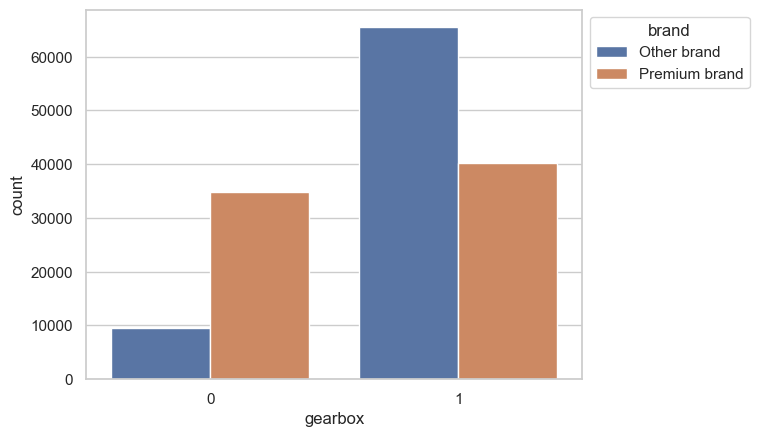

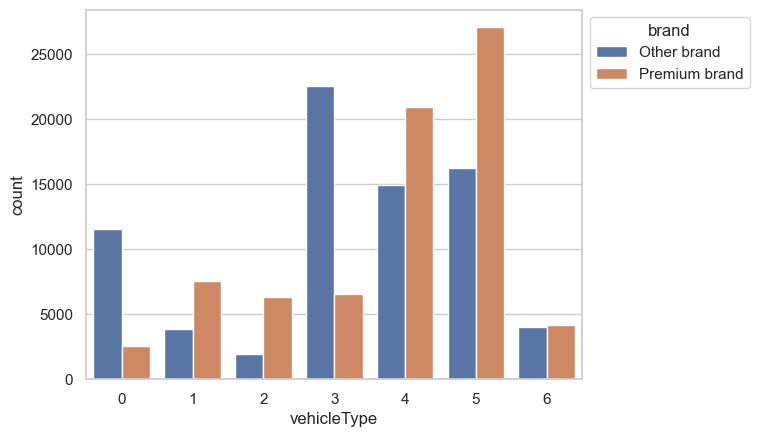

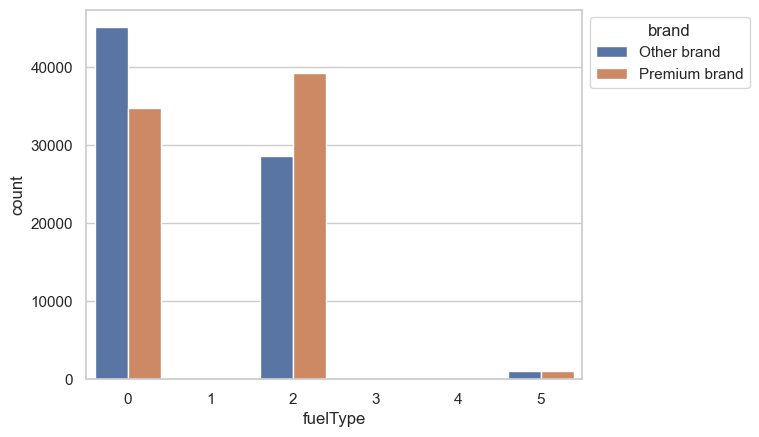

In [21]:
'''To visualize values, we'll take the convention:
- discrete values will be visualized by countplots,
- to display continuous variable we'll use KDE Plot.'''

'''
Observations:
1. Nearly 50% of premium brands cars have automatic gearbox in equipment - when it comes to other brands,
percentage falls below 20%.
2. Not premium brands have huge advantage (even four times more) in producing buses (0) and hatchbacks (3). In other segments 
(1 - cabrio, 2 - coupe, 4 - combi, 5 - sedans/limousines) premium brands have much more models on sale - mainly in first two
of mentioned categories. Numbers of SUV-s (6) are almost equal in both classes.
3. Premium brands have a little more diesels (2) than petrol (0) engines, not premium brands - over a half more petrol than diesel.
Other kinds of fuel (CNG - 1, electric - 3, hybrid - 4 and LPG - 5) have a marginal meaning.
'''

sns.set(style="whitegrid") 

for i, col in enumerate(df[encode_list]):
    plt.figure(i)
    ax = sns.countplot(x=col, data=df, hue='brand')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

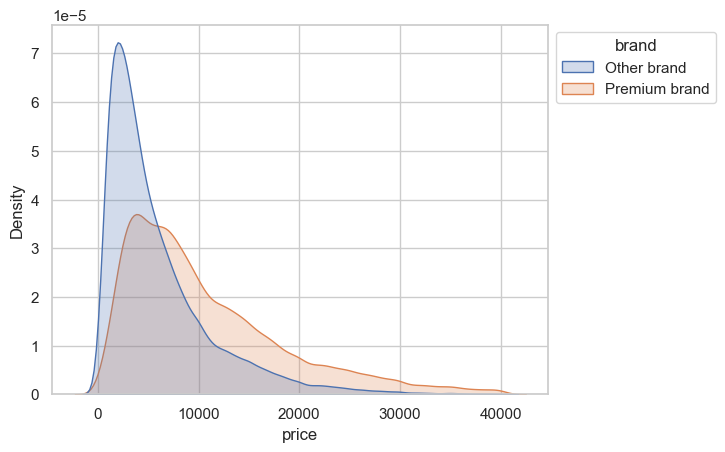

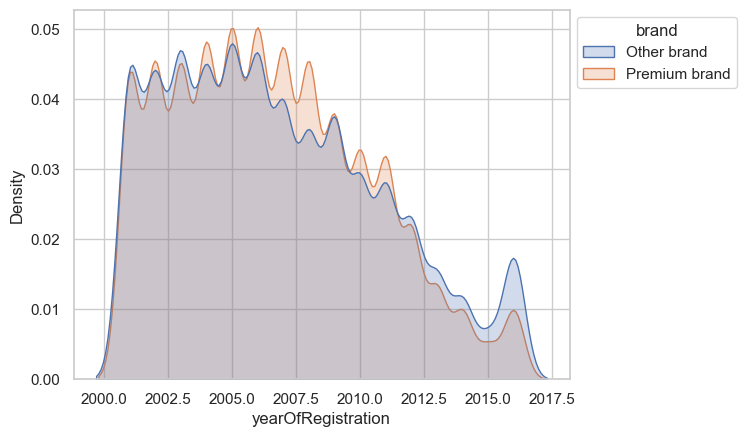

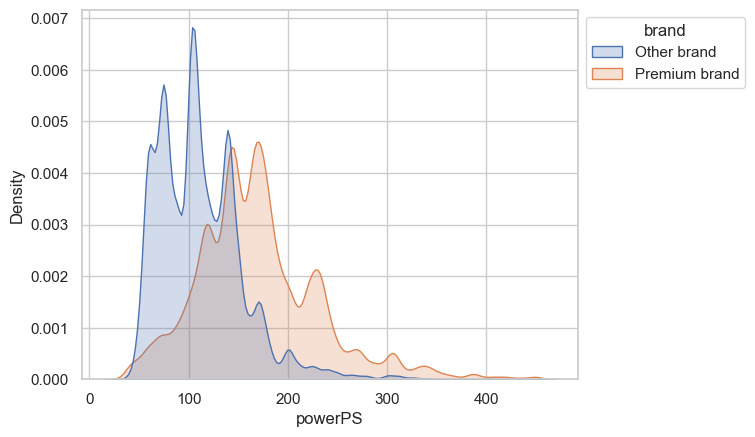

In [22]:
'''
When it comes to continuous variables:
1. Price distributions are both positive skew, but this of premium brands is much more flattened.
Non premium brands have the most models under 3000 euros, premium reaches peak at about 4000 euros.
At about 6000 euros distrubutions cross and premium brands start to have more models to offer.
Over 30000 euros almost all offered models are premium.
2. Distributions at "year of registration" column are quite similar, when it comes to years 2001-2005. 
Premium brands appear in more offers from years 2006-2011, offers of newer non premium cars (2012-2016) 
are much more frequent.
3. The biggest variance provides column "power PS". The biggest amount of non premium cars appear with power 
not exceeding 150 HP/PS (peak at about 100 HP) and then number falls drastically.
Premium cars more often have bigger power, exceeding even 400 HP (a little amount of non premium vehicles 
have more than 250 PS).

'''

for i, col in enumerate(df[['price', 'yearOfRegistration', 
                            'powerPS']]):#, 'advertDuration', 'priceOf1PS']]):
    plt.figure(i)
    ax = sns.kdeplot(x=col, data=df, hue='brand', fill=True)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [23]:
'''Analytic report shows that dependent variable has quite much correlation with variable "power". 
None of the independent variables have big correlations between them, so there's no need to perform 
feature extraction.
Also there's no variable with distribution similar to normal. We can also observe that report sees a visible
amount of duplicate rows, but it's probably due to the fact that some of the adverts refer to the similar car models.'''

report = ProfileReport(df, infer_dtypes=False)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
'''Using a pivot table we can take a look at descriptive stats of each brand.
Basing on mean, standard deviation and our previous observations we can see 
that the variables providing the greatest variance are: fuel type, engine power, gearbox and price.'''

pivot = pd.pivot_table(df, index='brand', values = ['price', 'vehicleType', 'yearOfRegistration',
                                                     'gearbox', 'powerPS', 'fuelType'], 
                       aggfunc= [np.mean, np.median, np.std, min, max])
pd.options.display.max_columns = None
display(pivot)

mean                                                  \
               fuelType   gearbox     powerPS         price vehicleType   
brand                                                                     
Other brand    0.839382  0.872012  111.423254   5946.509489    3.202704   
Premium brand  1.117347  0.536858  169.467404  10638.882773    3.779170   

                                   median                                      \
              yearOfRegistration fuelType gearbox powerPS   price vehicleType   
brand                                                                           
Other brand          2006.731677        0       1   105.0  4200.0           3   
Premium brand        2006.568436        2       1   163.0  8499.0           4   

                                       std                                    \
              yearOfRegistration  fuelType   gearbox    powerPS        price   
brand                                                                          
Other brand               2006.0  1.089692  0.334079  43.297994  5440.567170   
Premium brand             2006.0  1.094048  0.498643  62.066071  7887.585602   

                                                  min                         \
              vehicleType yearOfRegistration fuelType gearbox powerPS  price   
brand                                                                          
Other brand      1.766476           4.081767        0       0    35.0  200.0   
Premium brand    1.549536           3.790656        0       0    35.0  200.0   

                                                  max                  \
              vehicleType yearOfRegistration fuelType gearbox powerPS   
brand                                                                   
Other brand             0             2001.0        5       1   450.0   
Premium brand           0             2001.0        5       1   450.0   

                                                       
                 price vehicleType yearOfRegistration  
brand                                                  
Other brand    40000.0           6             2016.0  
Premium brand  40000.0           6             2016.0

In [25]:
'''Now we can divide dataset to features (X) and labels (y).'''

X = df.drop(columns='brand')
y = df['brand']

In [26]:
'''As we can see below, division of the set ended successfully.'''
print(X.sample(5))
print(y.sample(5))

            price  vehicleType  yearOfRegistration  gearbox  powerPS  fuelType
df_index                                                                      
89634     14000.0            6              2009.0        0    239.0         2
195704     5100.0            1              2003.0        1    116.0         0
217565     3300.0            3              2001.0        1    116.0         0
323699     4000.0            5              2002.0        1    131.0         2
107631     9490.0            4              2010.0        1    105.0         2
df_index
63099       Other brand
124277    Premium brand
210615    Premium brand
193751      Other brand
19396       Other brand
Name: brand, dtype: object


In [27]:
'''Now we should encode brand names into categorical numbers.'''

y = le.fit_transform(y)
print(y)
print(type(y))

[0 0 0 ... 1 1 1]
<class 'numpy.ndarray'>


In [28]:
'''We're going to need split the sets on training, validation and test via train_test_split method.'''

X_train, X_val, y_train, y_val = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 42,
                                                    stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_val,
                                                    y_val,
                                                    test_size = 0.5,
                                                    random_state = 42,
                                                    stratify=y_val)

print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (105119, 6)
X_val shape: (22525, 6)
X_test shape: (22526, 6)
y_train shape: (105119,)
y_val shape: (22525,)
y_test shape: (22526,)


In [37]:
'''Normalization of X sets using StandardScaler.'''

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)

In [54]:
'''Time for modelling. To solve classification problem we've chosen XGBClassifier.
It's efficient classifier which advantage is gradient boosting, using to improve the results of learning,
basing on previous iteration faults.'''

xgb_model = xgb.XGBClassifier(
    max_depth=9, #depth of trees 
    n_estimators=500, #no of trees/epochs - not to big to prevent overfitting
    learning_rate=0.1, #step size shrinkage - the next learning iteration should be smaller to prevent overfitting; less value demands more iterations
    objective='binary:logistic', #because it's binary classification issue, the objective couldn't be other
    eval_metric='error', #measure of model learning progress and the base of possible early stopping
    gamma=0.05, #minimum loss reduction required to make a further partition on a leaf node of the tree
    reg_lambda = 0.7, #L2 regularization term
    reg_alpha = 0.05, #L1 regularization term
    tree_method='approx' #the tree construction algorithm - approximate greedy algorithm using quantile sketch and gradient histogram
    #other params - default
)

start = time.time()
xgb_model.fit(
    X_train_sc, y_train,
    eval_set=[(X_train_sc, y_train), (X_val_sc, y_val)], #evaluation - on validation set
    early_stopping_rounds=15 #after 15 iterations with no progress training will be interrupted
)

xgb_model_train_pred = xgb_model.predict(X_train_sc)
stop = time.time()
mins = math.floor((stop - start)/60)
seconds = math.ceil((stop - start)%60)
print(f"Training time of XGBClassifier model: {mins} mins and {seconds} s.")

[0]	validation_0-error:0.16162	validation_1-error:0.16386
[1]	validation_0-error:0.15344	validation_1-error:0.15605
[2]	validation_0-error:0.15147	validation_1-error:0.15245
[3]	validation_0-error:0.14896	validation_1-error:0.14935
[4]	validation_0-error:0.14652	validation_1-error:0.14752
[5]	validation_0-error:0.14286	validation_1-error:0.14508
[6]	validation_0-error:0.14257	validation_1-error:0.14446
[7]	validation_0-error:0.14182	validation_1-error:0.14380
[8]	validation_0-error:0.14134	validation_1-error:0.14322
[9]	validation_0-error:0.13997	validation_1-error:0.14286
[10]	validation_0-error:0.13964	validation_1-error:0.14255
[11]	validation_0-error:0.13897	validation_1-error:0.14162
[12]	validation_0-error:0.13727	validation_1-error:0.13931
[13]	validation_0-error:0.13764	validation_1-error:0.14016
[14]	validation_0-error:0.13343	validation_1-error:0.13589
[15]	validation_0-error:0.13198	validation_1-error:0.13554
[16]	validation_0-error:0.13060	validation_1-error:0.13287
[17]	va

In [55]:
'''Let's display metrics of model.'''

xgb_model_val_pred = xgb_model.predict(X_val_sc)
xgb_model_test_pred = xgb_model.predict(X_test_sc)
print(f'Training metrics:\n\n{classification_report(y_train, xgb_model_train_pred)}')
print('_____________________________________________________\n')
print(f'Validation metrics:\n\n{classification_report(y_val, xgb_model_val_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, xgb_model_test_pred)}')

Training metrics:

              precision    recall  f1-score   support

           0       0.92      0.91      0.92     52559
           1       0.91      0.92      0.92     52560

    accuracy                           0.92    105119
   macro avg       0.92      0.92      0.92    105119
weighted avg       0.92      0.92      0.92    105119

_____________________________________________________

Validation metrics:

              precision    recall  f1-score   support

           0       0.90      0.89      0.90     11263
           1       0.90      0.90      0.90     11262

    accuracy                           0.90     22525
   macro avg       0.90      0.90      0.90     22525
weighted avg       0.90      0.90      0.90     22525

_____________________________________________________

Test metrics:

              precision    recall  f1-score   support

           0       0.90      0.89      0.89     11263
           1       0.89      0.90      0.89     11263

    accuracy     

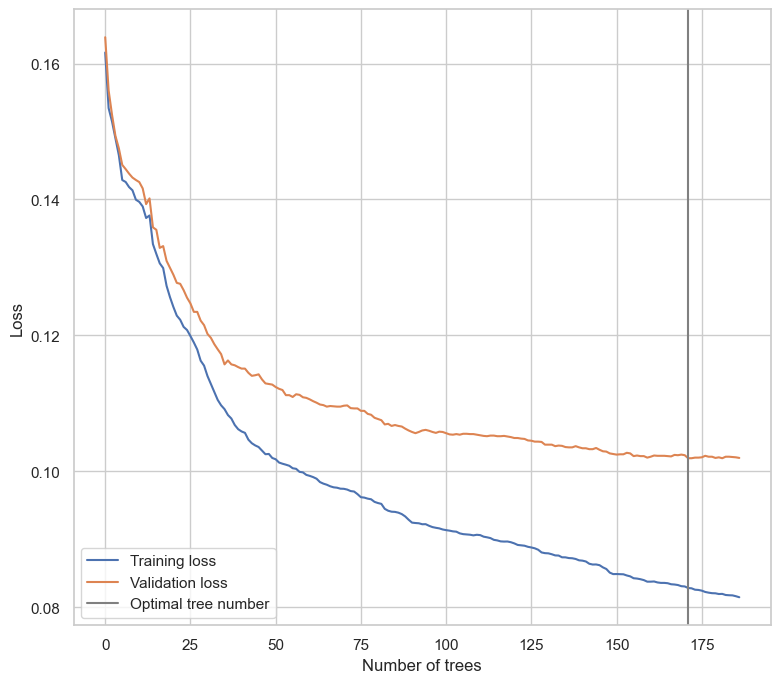

In [56]:
'''Model's metrics are good - 92% on training, 90% on validation and 89% on test set.
We should also make plots showing the course of loss function for training and validation set and displaying, 
at which iteration training was optimal.'''

results = xgb_model.evals_result()

plt.figure(figsize=(9,8))
plt.plot(results["validation_0"]["error"], label="Training loss")
plt.plot(results["validation_1"]["error"], label="Validation loss")
plt.axvline(xgb_model.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

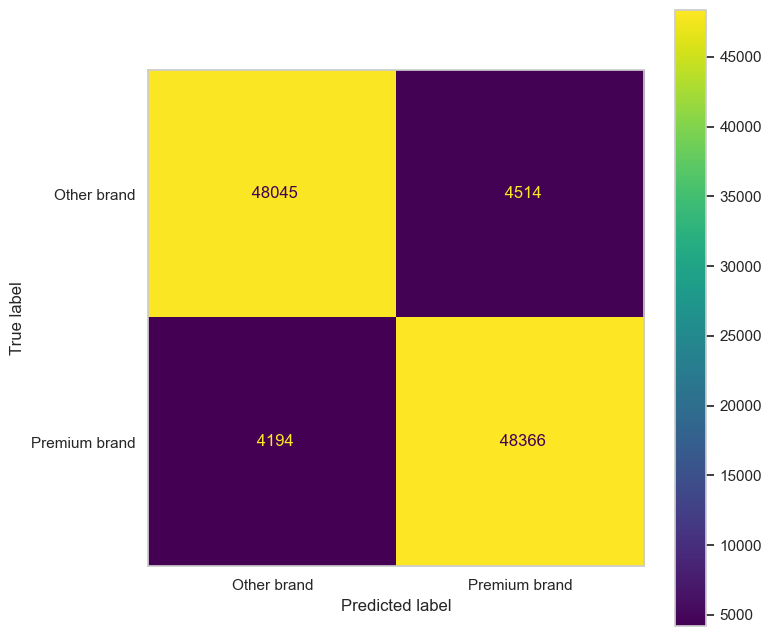

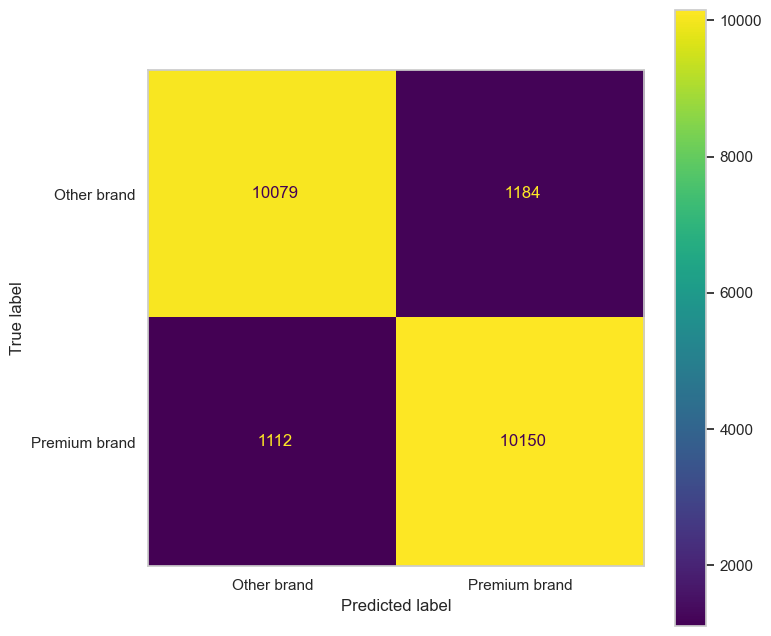

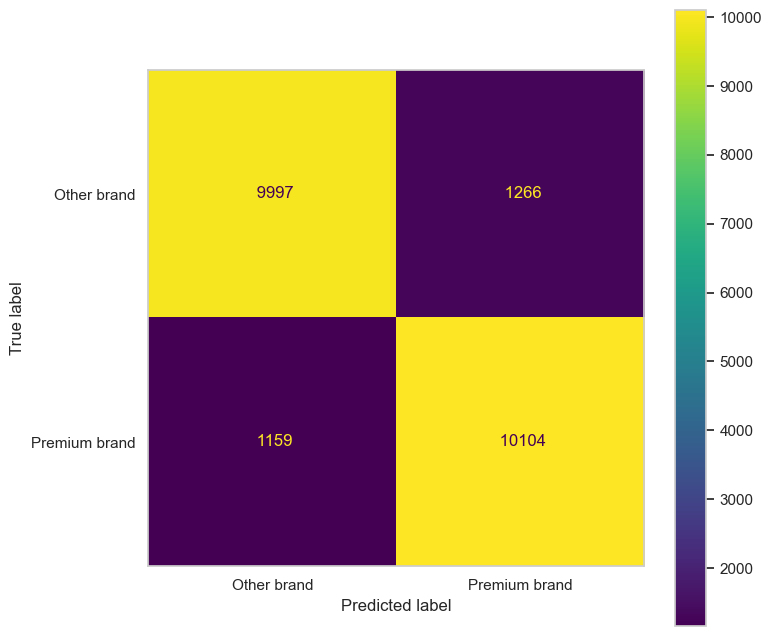

In [57]:
'''To visualize confusion matrix by heatmap, we'll create a function and call it for each set.'''

brands = le.classes_

def conf_matrix_show(estimator, X, y, classes):
    #1. Drawing the plot, setting the plot's default size.
    fig, ax = plt.subplots(figsize=(8,8))
    #2. Creating the instance of confusion matrix from estimator and set, and displaying classes to predict.
    cmd = ConfusionMatrixDisplay.from_estimator(estimator, X, y, display_labels=classes, ax=ax, values_format=' ')
    #3. Disabling grid - it makes confusion matrix much more readable. 
    ax.grid(False)

    
conf_matrix_show(xgb_model, X_train_sc, y_train, brands)
conf_matrix_show(xgb_model, X_val_sc, y_val, brands)
conf_matrix_show(xgb_model, X_test_sc, y_test, brands)

In [ ]:
'''At the end, let's random decision tree from estimators ensemble.'''

fig, ax = plt.subplots(figsize=(50,50))
xgb.plot_tree(xgb_model, num_trees=1, rankdir='LR', ax=ax)
plt.show()